In [1]:
!pip install -q osmnx geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.4/338.4 kB 9.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [2]:
#Import libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import numpy as np

# reproducible
np.random.seed(42)  

In [3]:
# Load from GeoPackage
gdf = gpd.read_file("/kaggle/input/kenya-map-data/kenya_admin.gpkg", layer="country")
counties = gpd.read_file("/kaggle/input/kenya-map-data/kenya_admin.gpkg", layer="counties")



In [4]:
# Load CSV of counties
counties_csv = pd.read_csv("/kaggle/input/kenya-census-data/kenya_census_data.csv")

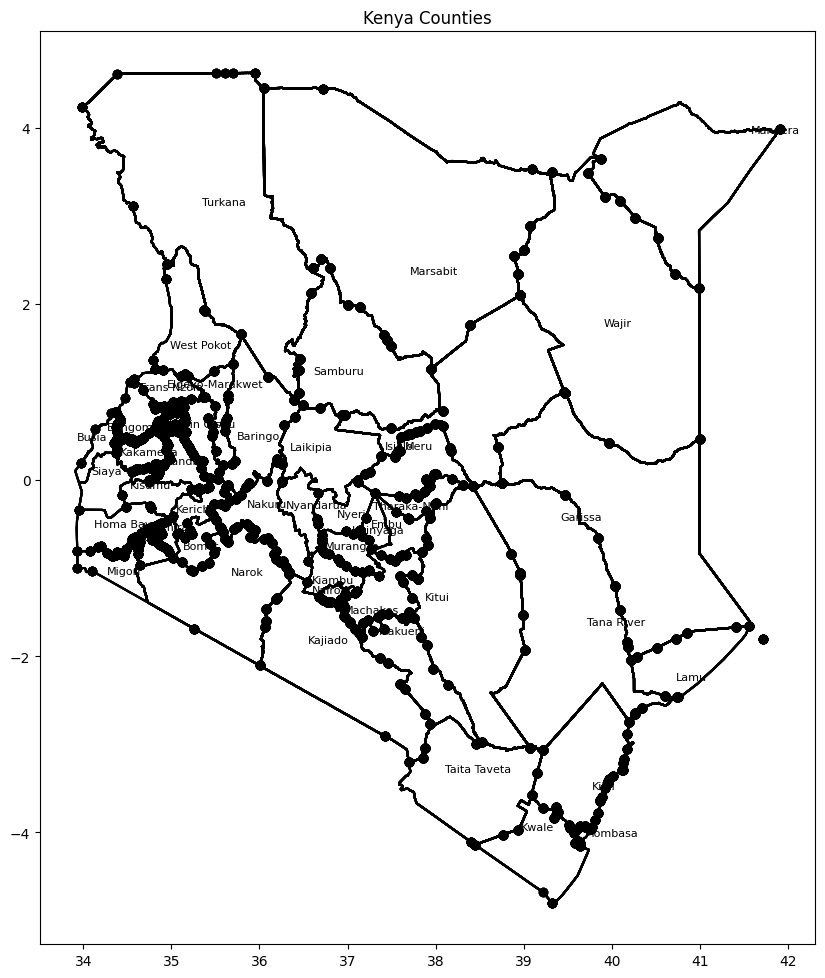

In [5]:
#Get Kenya polygon
kenya_poly = gdf.iloc[0].geometry

#add county boundaries (not sure if this is working right)
counties = gpd.clip(counties, kenya_poly)
# Plot counties
fig, ax = plt.subplots(figsize=(10, 12))
counties.boundary.plot(ax=ax, color="black")

# Overlay centroid labels from CSV
for _, row in counties_csv.iterrows():
    ax.text(row["Longitude"], row["Latitude"], row["County"], fontsize=8, ha="center")

ax.set_title("Kenya Counties")
plt.show()

In [6]:
# # get admin boundaries overlapping Kenya
# tags = {"boundary": "administrative"}
# gdf_admin = ox.features_from_polygon(kenya_poly, tags)

In [7]:
# keep only counties (admin_level=4)
gdf_counties = gpd.read_file("/kaggle/input/kenya-map-data/kenya_admin_levels.geojson")

In [8]:
#gdf_admin[gdf_admin["admin_level"] == "4"].copy()

'''
1. Filter only Kenyan counties

Many Kenyan counties in OSM have an ISO3166-2 code like KE-xx.
So you can drop anything that doesn’t start with KE-.
'''
if "ISO3166-2" in gdf_counties.columns:
    gdf_counties = gdf_counties[gdf_counties["ISO3166-2"].str.startswith("KE-", na=False)]

# clean up labels

# Use name:en (English) if available, else fall back to name or official_name.

if "name:en" in gdf_counties.columns:
    gdf_counties["label"] = (
        gdf_counties["name:en"]
        .fillna(gdf_counties["name"])
        .fillna(gdf_counties["official_name"])
    )
else:
    gdf_counties["label"] = gdf_counties["name"]

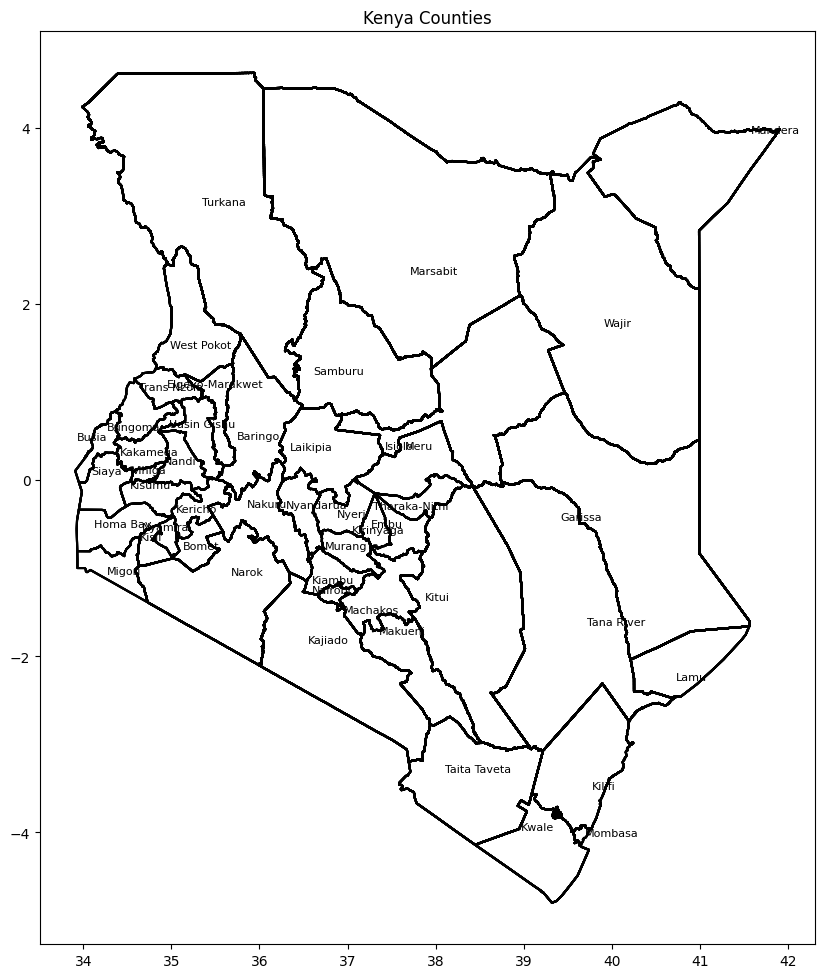

In [9]:
# Plot counties
fig, ax = plt.subplots(figsize=(10, 12))
gdf_counties.boundary.plot(ax=ax, color="black")

# Overlay centroid labels from CSV
for _, row in counties_csv.iterrows():
    ax.text(row["Longitude"], row["Latitude"], row["County"], fontsize=8, ha="center")

ax.set_title("Kenya Counties")
plt.show()

In [10]:
counties_csv['electrified_households'] = counties_csv['Conventional Households']*counties_csv['Mains Electricity']/100.0 

In [11]:
counties_csv['pop_per_household'] = counties_csv['TOTAL_POP']/counties_csv['Conventional Households'] 

In [12]:
counties_csv.head()

,CODE,County,Conventional Households,Mains Electricity,UNIT_AREA,UNIT_PERIM,COUNT,COUNTY_NAM,TOTAL_POP,POP_DENSIT,geometry,ISO_Code,Latitude,Longitude,CHME,PPH,electrified_households,pop_per_household
0,1,Mombasa,376295,85.9,0.023356,0.967209,34,Mombasa,1208333,517.354427,NaN,KE-28,-4.0435,40.0000,323237,3.0,323237.405,3.211132
1,2,Kwale,172802,31.5,0.758340,4.378790,83,Kwale,866820,11.430493,NaN,KE-19,-3.9737,39.1521,54433,5.0,54432.630,5.016261
2,3,Kilifi,297990,38.5,0.391775,3.909102,107,Kilifi,1453787,37.107702,NaN,KE-14,-3.5107,39.9093,114726,5.0,114726.150,4.878644
3,4,Tana River,66984,25.6,3.185316,10.410747,92,Tana River,315943,0.991873,NaN,KE-40,-1.6500,40.0500,17148,5.0,17147.904,4.716694
4,5,Lamu,34231,43.2,0.743918,3.771571,40,Lamu,143920,1.934622,"POLYGON ((642522.8810571186 9778754.915494535,...",KE-21,-2.2717,40.9020,14788,4.0,14787.792,4.204376


In [13]:
# Ensure county names are clean on both sides
counties["name"] = counties["name"].str.strip().str.title()
counties_csv.drop(columns = ['geometry'],inplace=True)
# Merge CSV with OSMnx data
counties_merged = gdf_counties.merge(counties_csv, left_on="name", right_on="County", how="outer")

# Now counties_merged has both geometries + centroid info
#save counties merged.

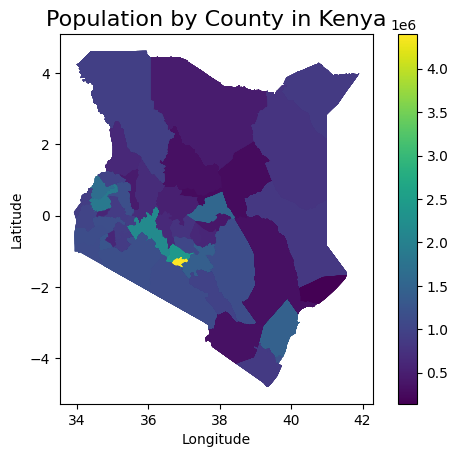

In [14]:
ax = counties_merged.plot(column="TOTAL_POP", legend=True)
plt.title("Population by County in Kenya", fontsize=16)
#plt.axis("off")  # optional, to hide axes
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

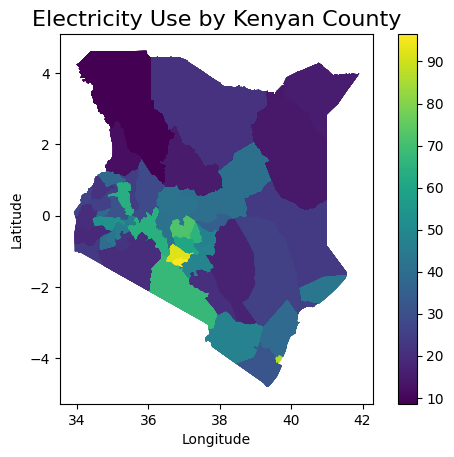

In [15]:
ax = counties_merged.plot(column="Mains Electricity", legend=True)
plt.title("Electricity Use by Kenyan County", fontsize=16)
#plt.axis("off")  # optional, to hide axes
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

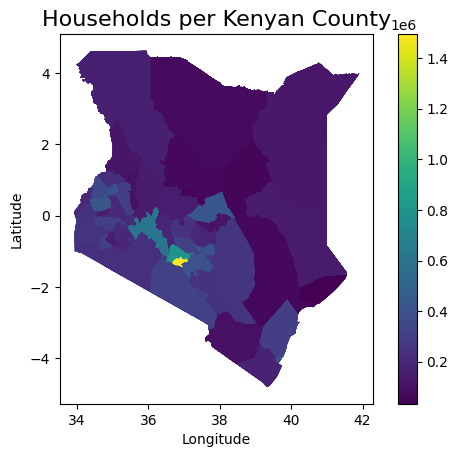

In [16]:
ax = counties_merged.plot(column="Conventional Households", legend=True)
plt.title("Households per Kenyan County", fontsize=16)
#plt.axis("off")  # optional, to hide axes
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

In [17]:
counties_merged[counties_merged['CODE']==1]

,element,id,admin_level,border_type,boundary,name,source,left:country,right:country,right:province,...,COUNTY_NAM_y,TOTAL_POP,POP_DENSIT,ISO_Code,Latitude,Longitude,CHME,PPH,electrified_households,pop_per_household
291,relation,3495554,4,None,administrative,Mombasa,None,None,None,None,...,Mombasa,1208333,517.354427,KE-28,-4.0435,40.0,323237,3.0,323237.405,3.211132
292,relation,3495554,4,None,administrative,Mombasa,None,None,None,None,...,Mombasa,1208333,517.354427,KE-28,-4.0435,40.0,323237,3.0,323237.405,3.211132
293,relation,3495554,4,None,administrative,Mombasa,None,None,None,None,...,Mombasa,1208333,517.354427,KE-28,-4.0435,40.0,323237,3.0,323237.405,3.211132
294,relation,3495554,4,None,administrative,Mombasa,None,None,None,None,...,Mombasa,1208333,517.354427,KE-28,-4.0435,40.0,323237,3.0,323237.405,3.211132


In [18]:
counties_csv[counties_csv['CODE']==6]

,CODE,County,Conventional Households,Mains Electricity,UNIT_AREA,UNIT_PERIM,COUNT,COUNTY_NAM,TOTAL_POP,POP_DENSIT,ISO_Code,Latitude,Longitude,CHME,PPH,electrified_households,pop_per_household
5,6,Taita Taveta,94468,47.6,1.394121,5.835375,77,Taita Taveta,340671,2.443626,KE-39,-3.3167,38.4833,44967,4.0,44966.768,3.606205


In [19]:
gdf_counties["name"].unique()

array(['Kisii', 'Narok', 'Homa Bay', 'Migori', 'Kajiado', 'Kisumu',
       'Nyamira', 'Busia', 'Vihiga', 'Machakos', 'Makueni', 'Nairobi',
       'Baringo', 'Bungoma', 'Embu', 'Garissa', 'Isiolo', 'Kiambu',
       'Kilifi', 'Kirinyaga', 'Kitui', 'Kwale', 'Laikipia', 'Lamu',
       'Marsabit', 'Meru', 'Mombasa', 'Nandi', 'Nyandarua', 'Nyeri',
       'Samburu', 'Taita Taveta', 'Tana River', 'Tharaka-Nithi',
       'Turkana', 'Uasin Gishu', 'Murang`a', 'West Pokot',
       'Elgeyo-Marakwet', 'Bomet', 'Nakuru', 'Kakamega', 'Siaya',
       'Mandera', 'Kericho', 'Wajir', 'Trans Nzoia'], dtype=object)

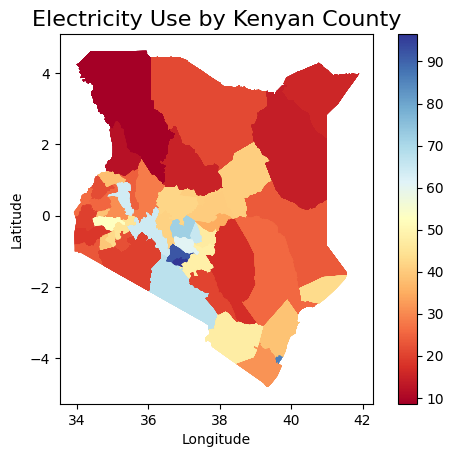

In [20]:
ax = counties_merged.plot(column="Mains Electricity", legend=True,cmap="RdYlBu")
plt.title("Electricity Use by Kenyan County", fontsize=16)
#plt.axis("off")  # optional, to hide axes
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

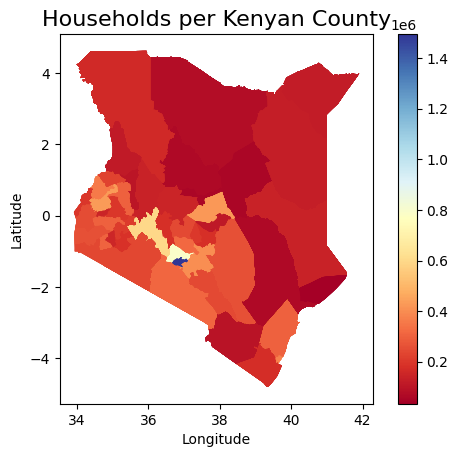

In [21]:
ax = counties_merged.plot(column="Conventional Households", legend=True,cmap="RdYlBu")
plt.title("Households per Kenyan County", fontsize=16)
#plt.axis("off")  # optional, to hide axes
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

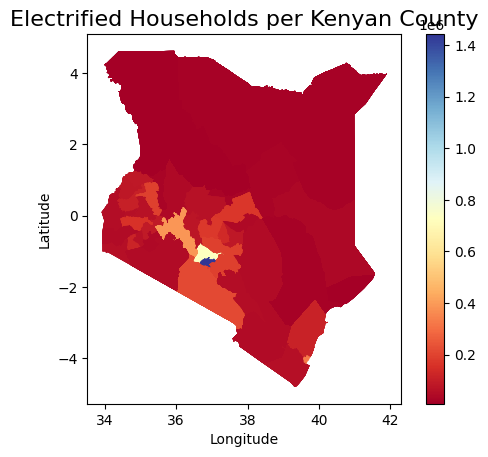

In [22]:
ax = counties_merged.plot(column="electrified_households", legend=True,cmap="RdYlBu")
plt.title("Electrified Households per Kenyan County", fontsize=16)
#plt.axis("off")  # optional, to hide axes
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

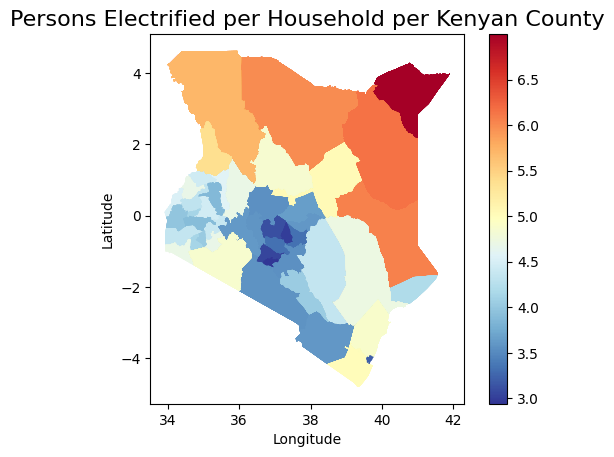

In [23]:
ax = counties_merged.plot(column="pop_per_household", legend=True,cmap="RdYlBu_r") #cmap="RdYlBu_r",   # reversed Red-Yellow-Blue

plt.title("Persons Electrified per Household per Kenyan County", fontsize=16)
#plt.axis("off")  # optional, to hide axes
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

Assess transformer data

In [24]:
import geopandas as gpd

url = "/kaggle/input/kenya-power-network-data/distribution_transformers.json"
gdf = gpd.read_file(url)
print(gdf.head())


   FID  OBJECTID                RCC1        County2              Branch3  \
0    0         1  Juja-Nairobi North  Nairobi North  Parklands - Kitsuru   
1    1         2  Juja-Nairobi North  Nairobi North  Parklands - Kitsuru   
2    2         3  Juja-Nairobi North  Nairobi North  Parklands - Kitsuru   
3    3         4  Juja-Nairobi North  Nairobi North  Parklands - Kitsuru   
4    4         5  Juja-Nairobi North  Nairobi North  Parklands - Kitsuru   

                                           Substati9               DCS_Cate15  \
0  H-POLE STRUCTURE 50-315 KVA 11/0.433 K.V. (E /...  ( CODE 2 ) - SUBSTATION   
1                                            UNKNOWN                  UNKNOWN   
2  H-POLE CONCRETE STRUCTURE 50-315KVA 11/0.433KV...         ( CODE 3 ) - L.V   
3  H-POLE STRUCTURE 50-315 KVA 11/0.433 K.V. (E /...  ( CODE 2 ) - SUBSTATION   
4  H-POLE-WOODEN STRUCTURE 50-315 KVA 11/0.433 K....   ( CODE 1 ) - H. V./M.V   

     Modifyin25 Origin_o27 Feeder_o28 Substati29 HT_Isol

In [25]:
gdf.head()

,FID,OBJECTID,RCC1,County2,Branch3,Substati9,DCS_Cate15,Modifyin25,Origin_o27,Feeder_o28,Substati29,HT_Isola32,Road_Str38,Physical39,Road,geometry
0,0,1,Juja-Nairobi North,Nairobi North,Parklands - Kitsuru,H-POLE STRUCTURE 50-315 KVA 11/0.433 K.V. (E /...,( CODE 2 ) - SUBSTATION,1020_POT_INS,PARKLANDS,WELBECK,,FUSES,1st Parklands,1st Parklands-Ita road juncti,1ST PARKLANDS AVENUE,POINT (257569.268 9859954.629)
1,1,2,Juja-Nairobi North,Nairobi North,Parklands - Kitsuru,UNKNOWN,UNKNOWN,1020_POT_INS,PARKLANDS,WELBECK,,FUSES,ita road,next to starbright apartments,OFF 1ST EVE.PARKLANDS,POINT (257648.529 9860076.677)
2,2,3,Juja-Nairobi North,Nairobi North,Parklands - Kitsuru,H-POLE CONCRETE STRUCTURE 50-315KVA 11/0.433KV...,( CODE 3 ) - L.V,1020_POT_INS,PARKLANDS,WELBECK,OUTDOOR,FUSES,1st parklands avenue,Next to new executive ladies,1ST PARKLANDS AVENUE,POINT (257313.317 9860059.38)
3,3,4,Juja-Nairobi North,Nairobi North,Parklands - Kitsuru,H-POLE STRUCTURE 50-315 KVA 11/0.433 K.V. (E /...,( CODE 2 ) - SUBSTATION,1020_POT_INS,PARKLANDS,WELBECK,,FUSES,1st parklands avenue,opposite kingsbury court,1ST PARKLANDS AVENUE,POINT (257141.828 9860162.714)
4,4,5,Juja-Nairobi North,Nairobi North,Parklands - Kitsuru,H-POLE-WOODEN STRUCTURE 50-315 KVA 11/0.433 K....,( CODE 1 ) - H. V./M.V,1020_POT_INS,PARKLANDS,WELBECK,OUTDOOR,TAPLINS,1st parkland rd,next to kings bury court,1ST PARKLANDS AVENUE,POINT (257014.619 9860226.934)


<Axes: >

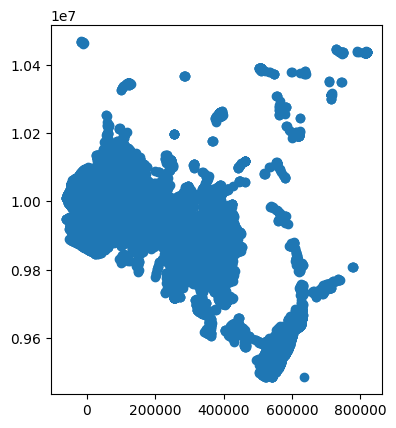

In [26]:
gdf.plot()

In [27]:
gdf = gdf.to_crs(epsg=4326)  # reproject to lat/lon

<Axes: >

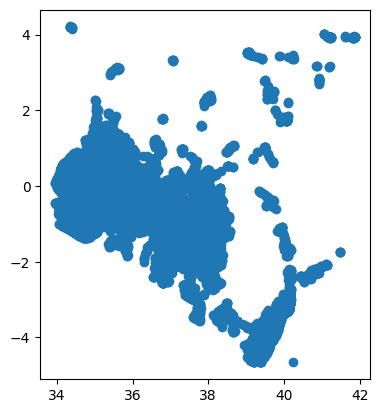

In [28]:
gdf.plot()

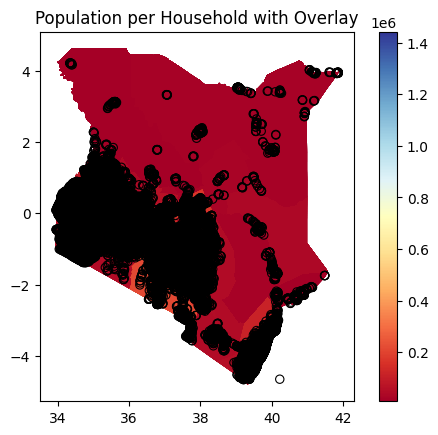

In [29]:
# First plot (base map)
ax = counties_merged.plot(column="electrified_households", legend=True,cmap="RdYlBu")
# Second plot overlayed on same ax
gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.8)

plt.title("Population per Household with Overlay")
plt.show()


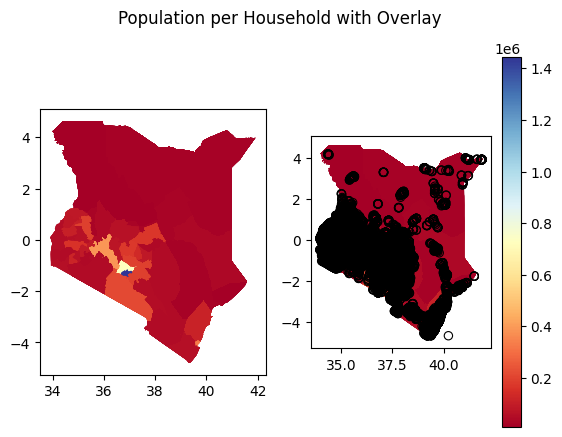

In [30]:
fig, ax = plt.subplots(1,2)
# First plot (base map)
counties_merged.plot(ax=ax[0], column="electrified_households", legend=not True,cmap="RdYlBu")
counties_merged.plot(ax=ax[1], column="electrified_households", legend=True,cmap="RdYlBu")
# Second plot overlayed on same ax
gdf.plot(ax=ax[1], facecolor="none", edgecolor="black", linewidth=0.8)

fig.suptitle("Population per Household with Overlay")
plt.show()

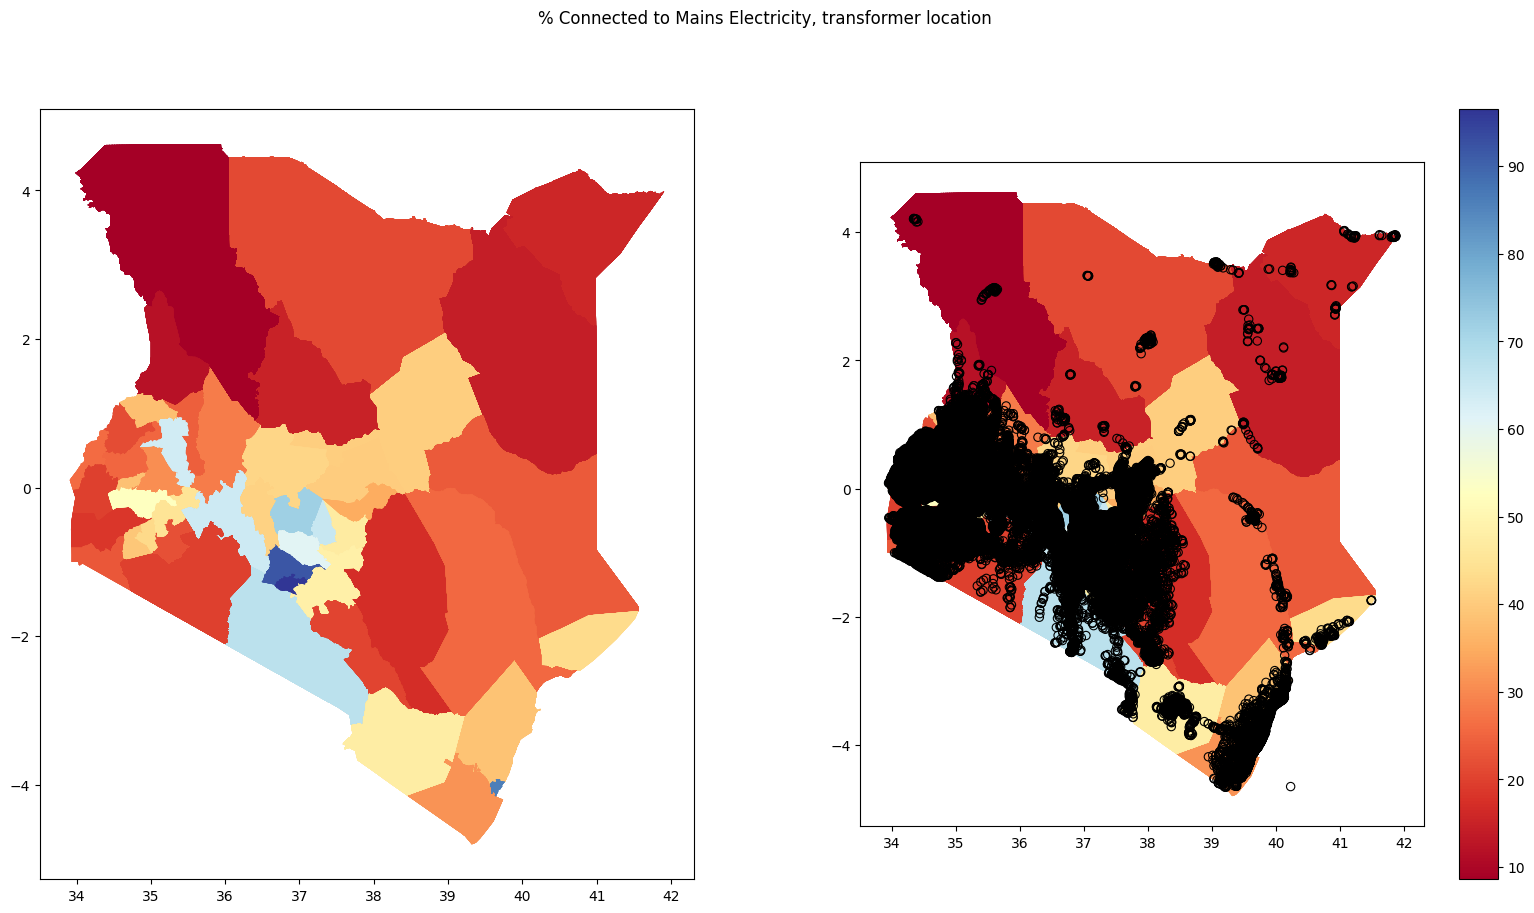

In [31]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
# First plot (base map)
counties_merged.plot(ax=ax[0], column="Mains Electricity", legend=not True,cmap="RdYlBu")
counties_merged.plot(ax=ax[1], column="Mains Electricity", legend=True,cmap="RdYlBu")
# Second plot overlayed on same ax
gdf.plot(ax=ax[1], facecolor="none", edgecolor="black", linewidth=0.8)

fig.suptitle("% Connected to Mains Electricity, transformer location")
plt.show()

In [32]:
cmc = list(counties_csv.columns)
print(cmc)
len(cmc)

['CODE', 'County', 'Conventional Households', 'Mains Electricity', 'UNIT_AREA', 'UNIT_PERIM', 'COUNT', 'COUNTY_NAM', 'TOTAL_POP', 'POP_DENSIT', 'ISO_Code', 'Latitude', 'Longitude', 'CHME', 'PPH', 'electrified_households', 'pop_per_household']


17

In [33]:
counties_merged['Mains Electricity per km2'] = counties_merged['electrified_households']/counties_merged['UNIT_AREA'] 

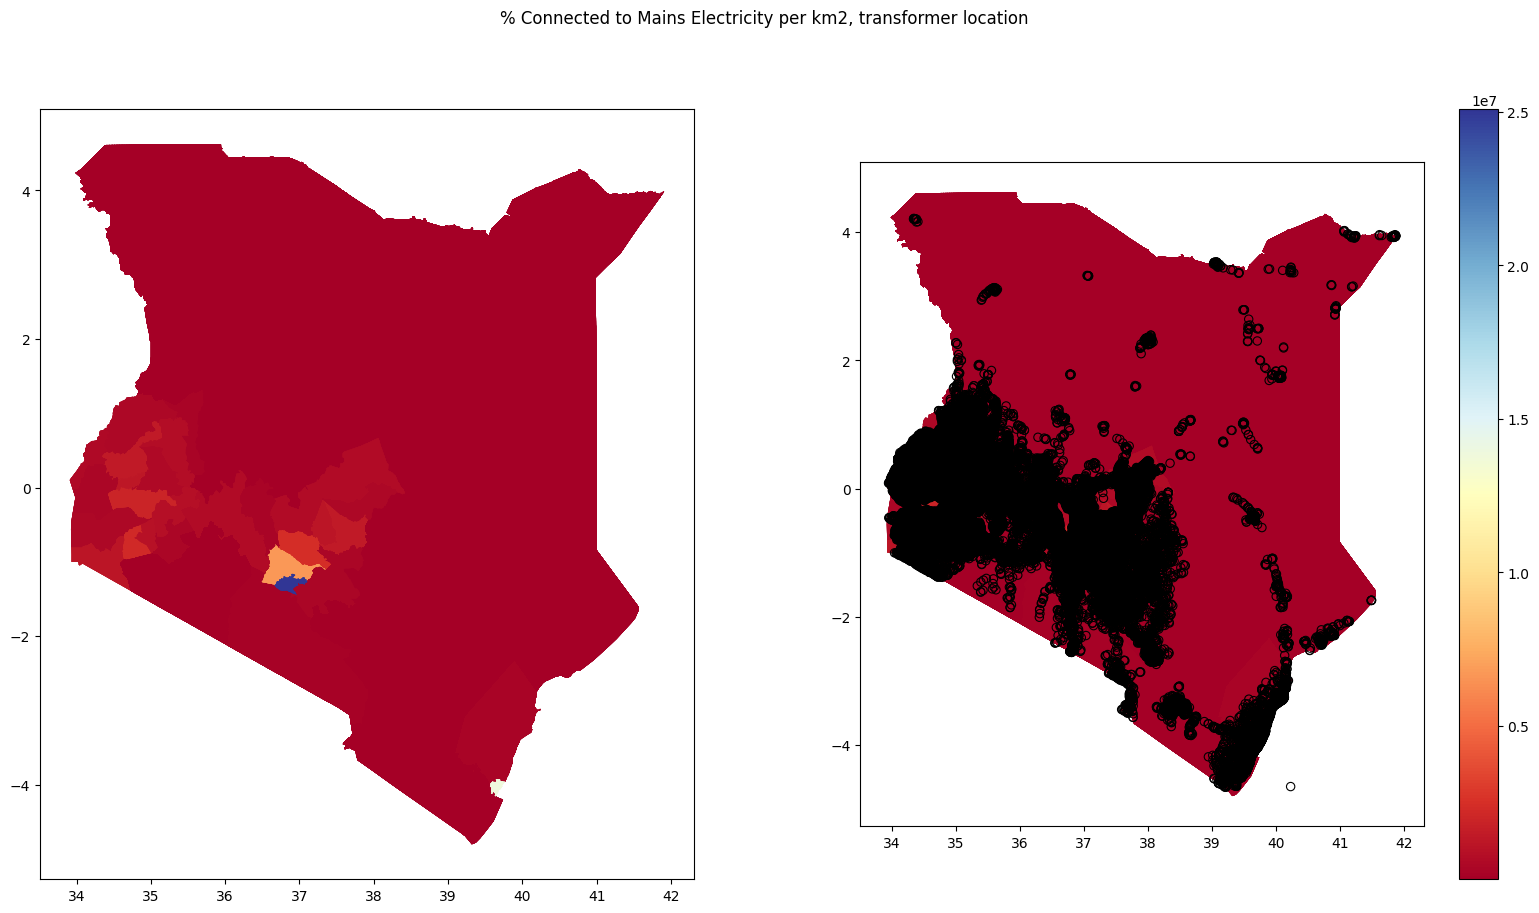

In [34]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
# First plot (base map)
counties_merged.plot(ax=ax[0], column="Mains Electricity per km2", legend=not True,cmap="RdYlBu")
counties_merged.plot(ax=ax[1], column="Mains Electricity per km2", legend=True,cmap="RdYlBu")
# Second plot overlayed on same ax
gdf.plot(ax=ax[1], facecolor="none", edgecolor="black", linewidth=0.8)

fig.suptitle("% Connected to Mains Electricity per km2, transformer location")
plt.show()

                             CODE  Conventional Households  Mains Electricity  \
CODE                     1.000000                 0.403235           0.162488   
Conventional Households  0.403235                 1.000000           0.581325   
Mains Electricity        0.162488                 0.581325           1.000000   
UNIT_AREA               -0.416794                -0.390965          -0.492648   
UNIT_PERIM              -0.418951                -0.387365          -0.463394   
COUNT                    0.175870                 0.278030          -0.122397   
TOTAL_POP                0.389197                 0.958213           0.401193   
POP_DENSIT               0.348119                 0.690574           0.466570   
Latitude                 0.110400                -0.252067          -0.492015   
Longitude               -0.865752                -0.261194          -0.089060   
electrified_households   0.289915                 0.923281           0.720745   
pop_per_household       -0.3

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


<Axes: >

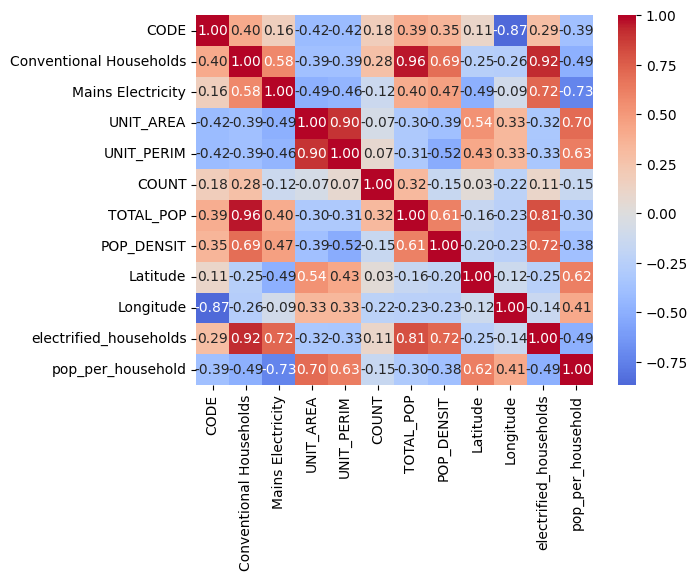

In [35]:
import seaborn as sns

corr = counties_merged.loc[:,['CODE','Conventional Households', 'Mains Electricity', 'UNIT_AREA', 'UNIT_PERIM', 'COUNT','TOTAL_POP', 'POP_DENSIT', 'Latitude', 'Longitude', 'electrified_households', 'pop_per_household']].corr()
print(corr)
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")

In [36]:
import mpld3
# Convert figure to HTML
html_str = mpld3.fig_to_html(fig)

with open("plot.html", "w") as f:
    f.write(html_str)

In [37]:
gdf.shape

(57360, 16)

In [38]:
gdf.columns

Index(['FID', 'OBJECTID', 'RCC1', 'County2', 'Branch3', 'Substati9',
       'DCS_Cate15', 'Modifyin25', 'Origin_o27', 'Feeder_o28', 'Substati29',
       'HT_Isola32', 'Road_Str38', 'Physical39', 'Road', 'geometry'],
      dtype='object')

In [39]:
gdf.County2.unique()

array(['Nairobi North', 'Nairobi West', 'Nairobi South', 'Kiambu',
       'Kajiado', 'Machakos', 'Mombasa', 'Kilifi', 'Kwale', 'Nakuru',
       'Nyandarua', "Murang'a", 'Taita Taveta', 'Makueni', 'Kitui',
       'Baringo', 'Tana River', 'Kisumu', 'Nyeri', 'Uasin Gishu',
       'Laikipia', 'Meru', 'Vihiga', 'Nandi', 'Kakamega',
       'Elgeyo Marakwet', 'Kirinyaga', 'Embu', 'Trans Nzoia',
       'West Pokot', 'Isiolo', 'Kericho', 'Bungoma', 'Siaya', 'Busia',
       'Narok', 'Nyamira', 'Homa Bay', 'Migori', 'Kisii', 'Tharaka Nithi',
       'Samburu', 'Bomet', 'Lamu', 'Turkana', 'Garissa', 'Marsabit',
       'Mandera', 'Wajir'], dtype=object)

In [40]:
gdf.County2.nunique()

49